In [1]:
### Import Libraries
import pandas as pd
import numpy as np
import os
import librosa
import matplotlib.pyplot as plt
from transformers import Wav2Vec2Processor, Wav2Vec2Model
import torch.nn as nn

c:\Users\andre\anaconda3\envs\python-cpu\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
protocol_dev_file = '../Dataset/ASVSpoof/actual/protocol_V2/ASVspoof2017_V2_dev.trl.txt'
protocol_train_file = '../Dataset/ASVSpoof/actual/protocol_V2/ASVspoof2017_V2_train.trn.txt'
protocol_eval_file = '../Dataset/ASVSpoof/actual/protocol_V2/ASVspoof2017_V2_eval.trl.txt'

In [3]:
folder_dev_file = '../Dataset/ASVSpoof/actual/ASVspoof2017_V2_dev'
folder_train_file = '../Dataset/ASVSpoof/actual/ASVspoof2017_V2_train'
folder_eval_file = '../Dataset/ASVSpoof/actual/ASVspoof2017_V2_eval'

In [4]:
### Load Protocol Files
df_dev = pd.read_csv(protocol_dev_file, sep=' ')
df_train = pd.read_csv(protocol_train_file, sep=' ')
df_eval = pd.read_csv(protocol_eval_file, sep=' ')

In [5]:
# Map labels
dev_labels = df_dev['type'].map({'genuine': 1, 'spoof': 0})
train_labels = df_train['type'].map({'genuine': 1, 'spoof': 0})
eval_labels = df_eval['type'].map({'genuine': 1, 'spoof': 0})

In [6]:
### Wav2Vec2 Setup
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
wav2vec_model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h")

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
# Custom Model
class Wav2Vec2ForLivenessDetection(nn.Module):
    def __init__(self, wav2vec_model):
        super(Wav2Vec2ForLivenessDetection, self).__init__()
        self.wav2vec = wav2vec_model
        self.classifier = nn.Linear(wav2vec_model.config.hidden_size, 2)

    def forward(self, input_values):
        outputs = self.wav2vec(input_values).last_hidden_state
        pooled_output = outputs.mean(dim=1)
        logits = self.classifier(pooled_output)
        return logits

In [8]:
### Audio Duration Calculation
def get_audio_durations(folder):
    durations = []
    for file in os.listdir(folder):
        file_path = os.path.join(folder, file)
        audio, sr = librosa.load(file_path, sr=None)
        duration = librosa.get_duration(y=audio, sr=sr)
        durations.append(duration)
    return durations

In [9]:
# Get durations
train_durations = get_audio_durations(folder_train_file)
median_duration = np.median(train_durations)
print(f"Median audio duration: {median_duration:.2f} seconds")

Median audio duration: 2.59 seconds


In [10]:
### Audio Normalization
def normalize_audio(audio):
    return audio / np.max(np.abs(audio))

### Padding and Truncating
def pad_and_truncate_audio(audio, target_duration, sample_rate):
    target_length = int(target_duration * sample_rate)
    if len(audio) < target_length:
        return np.pad(audio, (0, target_length - len(audio)), mode='constant')
    return audio[:target_length]

### Process Audio
def process_audio_files(folder):
    processed_audios = []
    for file in os.listdir(folder):
        file_path = os.path.join(folder, file)
        audio, sr = librosa.load(file_path, sr=16000)
        
        # Normalize, Pad & Truncate
        audio = normalize_audio(audio)
        audio = pad_and_truncate_audio(audio, median_duration, sr)
        
        processed_audios.append(audio)
    return processed_audios

In [11]:
# # Apply processing to datasets
# train_audios = process_audio_files(folder_train_file)
# eval_audios = process_audio_files(folder_eval_file)
# dev_audios = process_audio_files(folder_dev_file)

In [12]:
# # Save Processed Audio
# np.save('./Voice Liveness/train_audios.npy', train_audios)
# np.save('./Voice Liveness/eval_audios.npy', eval_audios)
# np.save('./Voice Liveness/dev_audios.npy', dev_audios)

In [13]:
# Load saved audios
train_audios = np.load('./Voice Liveness/Audio data read/train_audios.npy', allow_pickle=True)
eval_audios = np.load('./Voice Liveness/Audio data read/eval_audios.npy', allow_pickle=True)
dev_audios = np.load('./Voice Liveness/Audio data read/dev_audios.npy', allow_pickle=True)

In [14]:
import torch

In [15]:
def preprocess_audio(audio, processor, sample_rate=16000):
    inputs = processor(audio, sampling_rate=sample_rate, return_tensors="pt", padding=True)
    return inputs.input_values.squeeze(0)  # remove extra batch dimension

In [16]:
train_inputs = [preprocess_audio(audio, processor) for audio in train_audios]
eval_inputs = [preprocess_audio(audio, processor) for audio in eval_audios]
dev_inputs = [preprocess_audio(audio, processor) for audio in dev_audios]

In [17]:
from torch.utils.data import Dataset, DataLoader

In [18]:
class AudioDataset(Dataset):
    def __init__(self, audio_inputs, labels):
        self.audio_inputs = audio_inputs
        self.labels = labels

    def __len__(self):
        return len(self.audio_inputs)

    def __getitem__(self, idx):
        return self.audio_inputs[idx], torch.tensor(self.labels[idx])

In [19]:
# Initialize datasets
train_dataset = AudioDataset(train_inputs, train_labels)
eval_dataset = AudioDataset(eval_inputs, eval_labels)
dev_dataset = AudioDataset(dev_inputs, dev_labels)

In [20]:
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8)
eval_loader = DataLoader(eval_dataset, batch_size=8)
dev_loader = DataLoader(dev_dataset, batch_size=8)

In [21]:
import torch.optim as optim

In [22]:
# Initialize the model, optimizer, and loss function
model = Wav2Vec2ForLivenessDetection(wav2vec_model)
optimizer = optim.Adam(model.parameters(), lr=0.000005)
criterion = nn.CrossEntropyLoss()

In [23]:
# Training function
def train(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for audio_inputs, labels in train_loader:
        audio_inputs, labels = audio_inputs.to(device), labels.to(device)
        
        # Forward pass
        logits = model(audio_inputs)
        loss = criterion(logits, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    return total_loss / len(train_loader)

def evaluate(model, eval_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for audio_inputs, labels in eval_loader:
            audio_inputs, labels = audio_inputs.to(device), labels.to(device)
            logits = model(audio_inputs)
            loss = criterion(logits, labels)
            total_loss += loss.item()
            
            # Calculate accuracy
            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()
    
    avg_loss = total_loss / len(eval_loader)
    accuracy = correct / len(eval_loader.dataset)
    return avg_loss, accuracy

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Ensure the model is on the correct device

# Initialize lists to store losses for plotting
train_losses = []
dev_losses = []

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, optimizer, criterion, device)
    dev_loss, dev_accuracy = evaluate(model, dev_loader, criterion, device)
    
    # Append losses for plotting
    train_losses.append(train_loss)
    dev_losses.append(dev_loss)
    
    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Dev Loss: {dev_loss:.4f} | Dev Accuracy: {dev_accuracy:.4f}")

c:\Users\andre\anaconda3\envs\python-cpu\Lib\site-packages\transformers\models\wav2vec2\modeling_wav2vec2.py:863: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Epoch 1/10
Train Loss: 0.3482
Dev Loss: 1.4732 | Dev Accuracy: 0.5556
Epoch 2/10
Train Loss: 0.5442
Dev Loss: 1.3321 | Dev Accuracy: 0.5556
Epoch 3/10
Train Loss: 0.4642
Dev Loss: 1.3635 | Dev Accuracy: 0.5556
Epoch 4/10
Train Loss: 0.4745
Dev Loss: 1.2803 | Dev Accuracy: 0.5556
Epoch 5/10
Train Loss: 0.5959
Dev Loss: 1.2397 | Dev Accuracy: 0.5556
Epoch 6/10
Train Loss: 0.5945
Dev Loss: 1.1848 | Dev Accuracy: 0.5556
Epoch 7/10
Train Loss: 0.5226
Dev Loss: 1.2378 | Dev Accuracy: 0.5556
Epoch 8/10
Train Loss: 0.6522
Dev Loss: 1.0512 | Dev Accuracy: 0.5556
Epoch 9/10
Train Loss: 0.5498
Dev Loss: 1.1448 | Dev Accuracy: 0.5556
Epoch 10/10
Train Loss: 0.6077
Dev Loss: 1.0652 | Dev Accuracy: 0.5556


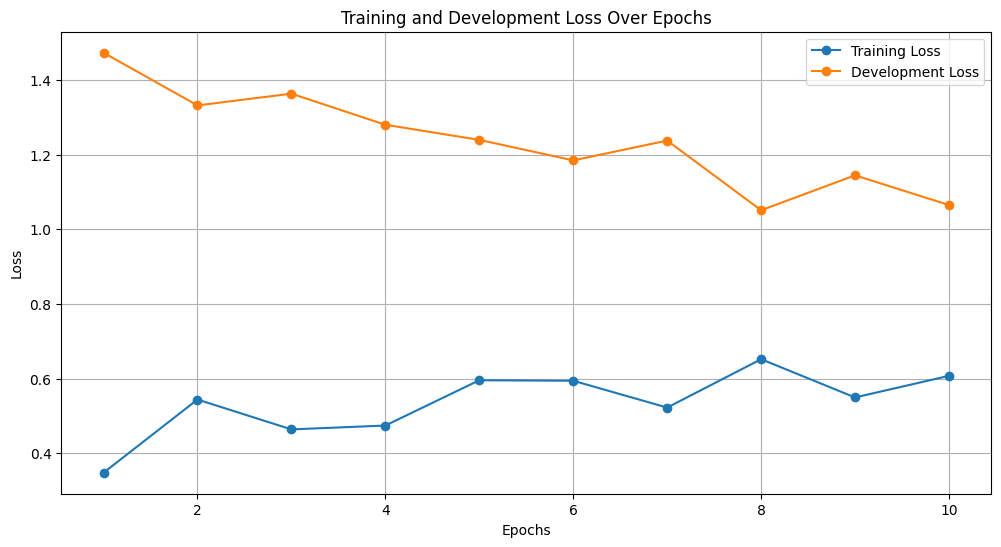

In [25]:
# Plotting the training and dev losses
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, num_epochs + 1), dev_losses, label='Development Loss', marker='o')
plt.title('Training and Development Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [26]:
model.eval()

Wav2Vec2ForLivenessDetection(
  (wav2vec): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )


In [27]:
all_preds = []
all_labels = []

with torch.no_grad():
    for audio_inputs, labels in eval_loader:
        audio_inputs, labels = audio_inputs.to(device), labels.to(device)
        logits = model(audio_inputs)
        preds = torch.argmax(logits, dim=1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [29]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [34]:
# Confusion matrix and classification report
conf_matrix = confusion_matrix(all_labels, all_preds)
report = classification_report(all_labels, all_preds, target_names=['Spoof', 'Genuine'])

c:\Users\andre\anaconda3\envs\python-cpu\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\andre\anaconda3\envs\python-cpu\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\andre\anaconda3\envs\python-cpu\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

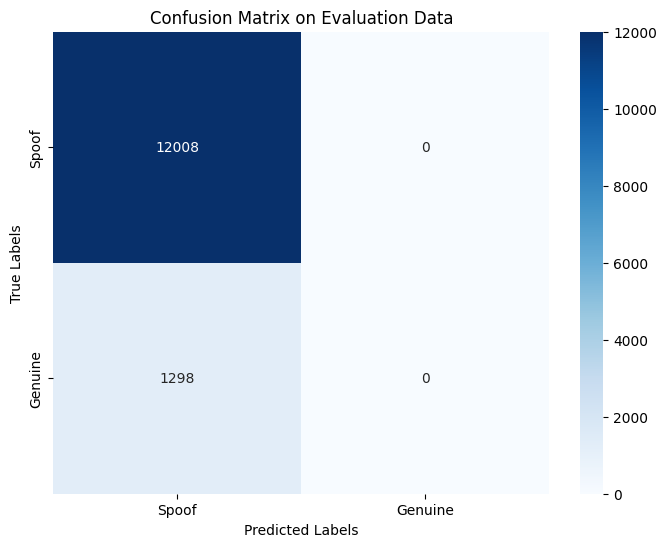

In [35]:
# Display confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Spoof', 'Genuine'], yticklabels=['Spoof', 'Genuine'])
plt.title("Confusion Matrix on Evaluation Data")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [36]:
# Display classification report
print("Classification Report on Evaluation Data:")
print(report)

Classification Report on Evaluation Data:
              precision    recall  f1-score   support

       Spoof       0.90      1.00      0.95     12008
     Genuine       0.00      0.00      0.00      1298

    accuracy                           0.90     13306
   macro avg       0.45      0.50      0.47     13306
weighted avg       0.81      0.90      0.86     13306

